In [45]:
import pandas as pd

Let's first import all four data files and inspect them for what information they actually carry. The accompanying PDF 'data_dictionary' files explain what is in each column.

In [48]:
df1 = pd.read_csv('data/fires_1961to1982.csv')
df2 = pd.read_csv('data/fires_1983to1995.csv', low_memory = False) # Columns (17,76,77) have mixed types
df3 = pd.read_csv('data/fires_1996to2005.csv')
# The most recent file has a 0x92 byte, which is a special apostrophe made by Windows
df4 = pd.read_csv('data/fires_2006to2017.csv', encoding='cp1252')

In [4]:
df3.columns

Index(['fire_number', 'fire_name', 'fire_year', 'calendar_year',
       'assessment_datetime', 'assessment_hectares', 'current_size',
       'size_class', 'fire_location_latitude', 'fire_location_longitude',
       'fire_origin', 'general_cause_desc', 'industry_identifier_desc',
       'responsible_group_desc', 'activity_class', 'true_cause',
       'permit_detail_desc', 'fire_start_date', 'det_agent_type', 'det_agent',
       'discovered_date', 'reported_date', 'start_for_fire_date',
       'fire_fighting_start_date', 'fire_fighting_start_size',
       'initial_action_by', 'fire_type', 'fire_position_on_slope',
       'weather_conditions_over_fire', 'fuel_type', 'other_fuel_type',
       'bh_fs_date', 'bh_hectares', 'uc_fs_date', 'uc_hectares', 'to_fs_date',
       'to_hectares', 'ex_fs_date', 'ex_hectares'],
      dtype='object')

Every one of these files has a different structure, so I'm going to manually find the ones I want. Right now, I care the most about:
- Year
- Total area burned by the fire (not every reading is the total area burned)

Later, we should filter out all identifiably artifical fires.

In [5]:
df = pd.DataFrame(columns = ['Year', 'Area'])

In [6]:
df1_sub = (df1.groupby(by = ['FIRENUMBER', 'YEAR'], sort = False)['TOTAL']
           .nlargest(n=1)
           .reset_index()
           .loc[:,['YEAR', 'TOTAL']]
           .rename(columns = {'YEAR': 'Year', 'TOTAL': 'Area'})
          )

# Data only recorded last two digits of year
df1_sub.loc[:,'Year'] = df1_sub['Year'].apply(lambda x: x+1900) 

# Total burned area is recorded in acres. Since metric is better, let's convert that to hectares
df1_sub.loc[:,'Area'] = df1_sub['Area'].apply(lambda x: x * 0.404686)

df = df.append(df1_sub, ignore_index=True, sort = False)

In [7]:
df2_sub = (df2.groupby(by = ['firenumber', 'fire_year'], sort = False)['grandarea']
           .nlargest(n=1)
           .reset_index()
           .loc[:,['fire_year', 'grandarea']]
           .rename(columns = {'fire_year': 'Year', 'grandarea': 'Area'})
          )

# Documentation says col `fire_year` is only last two digits, but it's identical to `calendar_year`
# Area is listed as already in hectares

df = df.append(df2_sub, ignore_index=True)

In [15]:
# The documentation for this period doesn't match the actual column names, but the one for 2006 to 2017 does
# These two periods have the same column headings, so let's save some time and merge them early
df3 = df3.append(df4)

# Use fire_year because some of these fires continued to burn even into the winter of the following year
# df3[df3.loc[:,['fire_year']].values != df3.loc[:,['calendar_year']].values]

# Current size is implicitly in hectares (matches other columns explicitly listed as hectares)

df3_sub = (df3.groupby(by = ['fire_number', 'fire_year'], sort = False)['current_size']
           .nlargest(n=1)
           .reset_index()
           .loc[:,['fire_year', 'current_size']]
           .rename(columns = {'fire_year': 'Year', 'current_size': 'Area'})
          )

df = df.append(df3_sub, ignore_index=True)

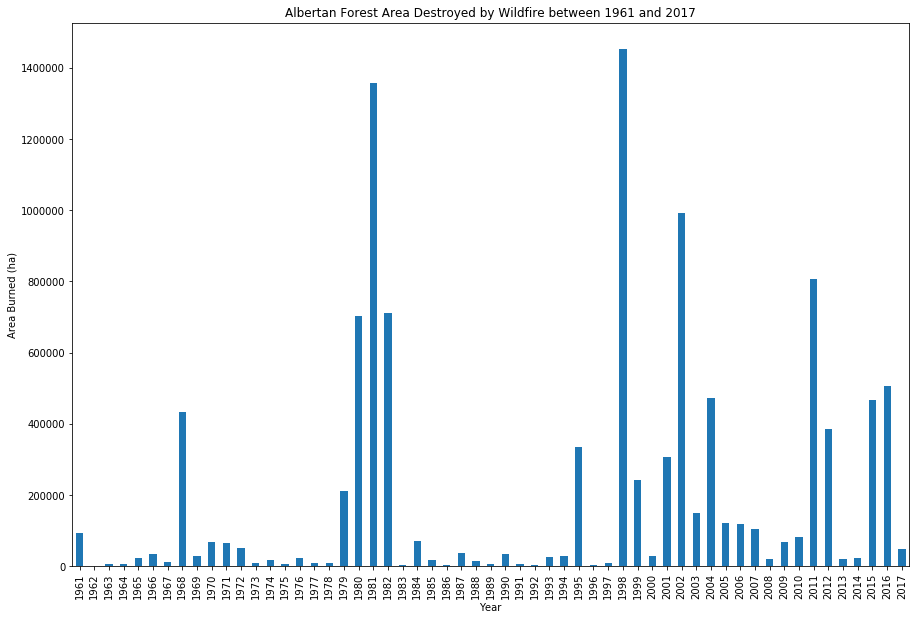

In [49]:
title = 'Albertan Forest Area Destroyed by Wildfire between 1961 and 2017'
fig = (df.groupby(by = 'Year').sum()
       .plot(
           kind = 'bar',
           figsize = (15, 10),
           title = title,
           legend = False
       )
       .set(xlabel="Year", ylabel="Area Burned (ha)")
      )